<style>
h1{font-family: 'lucida handwriting'}
</style>
<center>

# **Atelier :** <br>  Prédiction floue du risque de panne d’une machine industrielle
</center>

### **CHERGUI Moad**  
IID3

In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# **<u>Modélisation floue:**

## 1. Créez un contrôleur flou avec les variables suivantes
**Entrées :**
- Température ∈ [0,100]
   - Basse : [0,0,40]
   - Normale : [30,50,70]
   - Elevée : [60,100,100]
- Vibration ∈ [0,10]
   - Faible : [0,0,4]
   - Moyenne : [2,5,8]
   - Forte : [6,10,10]
- Âge ∈ [0,20]
   - Neuf : [0,0,7]
   - Moyen : [5,10,15]
   - Ancien : [12,20,20]

**Sortie :**
- Risque de panne ∈ [0,10]
   - Faible : [0,0,4]
   - Moyen : [2,5,8]
   - Elevé : [6,10,10]

In [2]:
# Définition des variables d'entrée
#temperature:
temperature = ctrl.Antecedent(np.arange(0, 101, 1), 'temperature')

temperature['basse'] = fuzz.trimf(temperature.universe, [0, 0, 40])
temperature['normale'] = fuzz.trimf(temperature.universe, [30, 50, 70])
temperature['elevée'] = fuzz.trimf(temperature.universe, [60, 100, 100])

#vibration:
vibration = ctrl.Antecedent(np.arange(0, 11, 1), 'vibration')

vibration['faible'] = fuzz.trimf(vibration.universe, [0, 0, 4])
vibration['moyenne'] = fuzz.trimf(vibration.universe, [2, 5, 8])
vibration['forte'] = fuzz.trimf(vibration.universe, [6, 10, 10])

#age:
age = ctrl.Antecedent(np.arange(0, 21, 1), 'age')

age['neuf'] = fuzz.trimf(age.universe, [0, 0, 7])
age['moyen'] = fuzz.trimf(age.universe, [5, 10, 15])
age['ancien'] = fuzz.trimf(age.universe, [12, 20, 20])



# Définition des variables de sortie
#risque de panne:
risque_panne = ctrl.Consequent(np.arange(0, 11, 1), 'risque_panne')

risque_panne['faible'] = fuzz.trimf(risque_panne.universe, [0, 0, 4])
risque_panne['moyen'] = fuzz.trimf(risque_panne.universe, [2, 5, 8])
risque_panne['élevé'] = fuzz.trimf(risque_panne.universe, [6, 10, 10])


## 2. Formuler les règles d’inférence floues
- Si la température est élevée ou la vibration est forte, alors le risque est élevé.
- Si la machine est ancienne et la vibration est moyenne, alors le risque est moyen.
- Si la température est basse et la vibration est faible et l’âge est neuf, alors le risque est faible.
- Si la température est normale et l’âge est moyen, alors le risque est moyen.

In [3]:
rule1 = ctrl.Rule(temperature['elevée'] | vibration['forte'], risque_panne['élevé'])
rule2 = ctrl.Rule(age['ancien'] & vibration['moyenne'], risque_panne['moyen'])
rule3 = ctrl.Rule(temperature['basse'] & vibration['faible'] & age['neuf'], risque_panne['faible'])
rule4 = ctrl.Rule(temperature['normale'] & age['moyen'], risque_panne['moyen'])

## 3. Créer et simuler le contrôleur :

Le risque de panne de la machine est de : 8.44/10


c:\Python310\lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


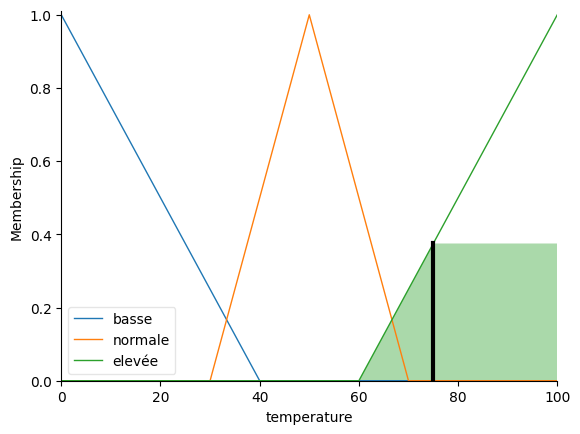

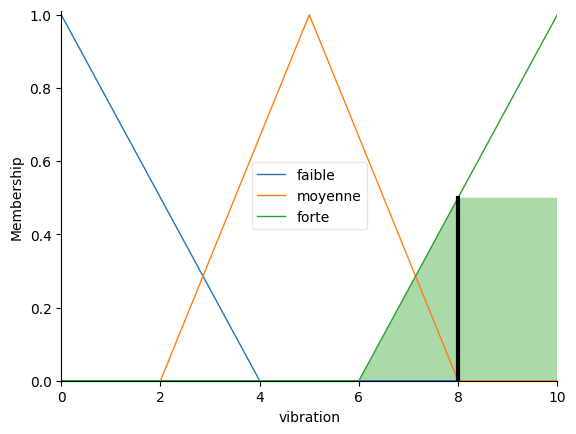

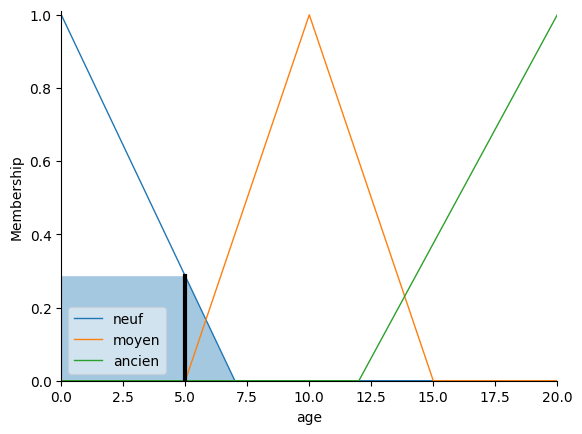

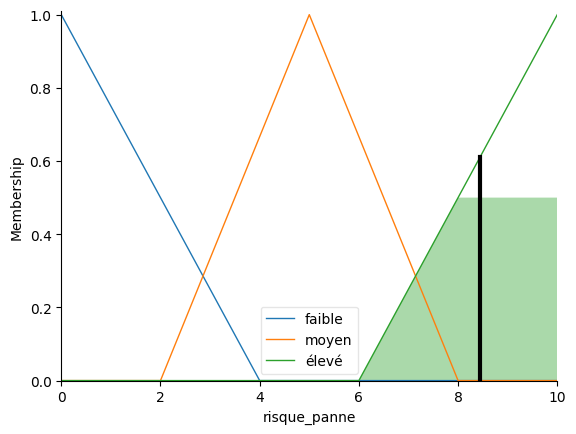

In [4]:
risk_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4])
risk_simulation = ctrl.ControlSystemSimulation(risk_ctrl)
risk_simulation.input['temperature'] = 75
risk_simulation.input['vibration'] = 8
risk_simulation.input['age'] = 5
risk_simulation.compute()
for antecedent in [temperature, vibration, age]:
    antecedent.view(sim=risk_simulation)
print(f"Le risque de panne de la machine est de : {risk_simulation.output['risque_panne']:.2f}/10")
risque_panne.view(sim=risk_simulation)

# **<u>Machine Learning:**

In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 1. Générer un dataset synthétique

In [ ]:

n_samples = 2000

temperature_samples = np.random.uniform(0, 100, n_samples)
vibration_samples = np.random.uniform(0, 10, n_samples)
age_samples = np.random.uniform(0, 20, n_samples)


(1725, 4)


,Temperature,Vibration,Age,Risk
0,60.958222,7.589695,19.043189,7.100924
1,15.872115,8.751571,17.349851,8.567680
2,87.230905,0.080089,15.090467,8.563671
3,31.621659,1.450623,13.125977,5.000000
4,53.659111,9.267078,19.689469,8.628834


## 2. Calculer pour chacun la valeur défuzzifiée du risque à partir du modèle flou

In [ ]:

risk_outputs = []
for (i,(t, v, a)) in enumerate(zip(temperature_samples, vibration_samples, age_samples)):
    risk_simulation.input['temperature'] = float(t)
    risk_simulation.input['vibration'] = float(v)
    risk_simulation.input['age'] = float(a)

    # rules may fail for some inputs

    try:
        risk_simulation.compute()
        risk_outputs.append(float(risk_simulation.output['risque_panne']))
    except Exception as e:
        risk_outputs.append(np.nan)
df = pd.DataFrame({
    'Temperature': temperature_samples,
    'Vibration': vibration_samples,
    'Age': age_samples,
    'Risk': risk_outputs
})
df=df.dropna()
print(df.shape)
df.head()

## 3. Entraîner un modèle de régression pour prédire le risque à partir des trois entrées

In [11]:
X = df[['Temperature', 'Vibration', 'Age']].values
y = df['Risk'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MSE = ", mean_squared_error(y_test, y_pred))
print("MAE = ", mean_absolute_error(y_test, y_pred))

MSE =  0.028955072691817862
MAE =  0.0640860612176684


# **<u>Interprétation et Analyse:**

### Logique floue

La logique floue offre une explicabilité totale grâce à des règles linguistiques claires (si...alors...) facilement compréhensibles par les humains, permettant de tracer précisément comment chaque décision est prise sans nécessiter de données d'entraînement.



### Machine learning

Le Machine Learning offre une précision supérieure en capturant automatiquement des relations complexes et non-linéaires dans les données, s'adaptant aux patterns réels et s'améliorant continuellement par réentraînement.
